In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib
import glob
from scipy.integrate import odeint
matplotlib.rcParams.update({'font.size': 18})
import calendar
month_names=[x[:3] for x in calendar.month_name[1:13]]
def_color=plt.rcParams['axes.color_cycle']

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [9]:
from sympy import *
u=Symbol('u')
b1=Symbol('b1')
b2=Symbol('b2')
b3=Symbol('b3')
a1=Symbol('a1')
a2=Symbol('a2')
a3=Symbol('a3')
x1=Symbol('x1')
x2=Symbol('x2')
x3=Symbol('x3')
P=Symbol('P')
A=Symbol('A')

amp=0.1

stst=solve([u*b1/x3-a1*x1,b2*x1*P/x3-a2*x2,b3*x2*A-a3*x3],[x1,x2,x3])[0]

def get_seasonal_data(file_path,gender='both'):
    dat=pd.read_csv(file_path)
    if gender=='female':
        return dat[(dat['type']=='female')]
    if gender=='male':
        return dat[(dat['type']=='male')]
    return dat[(dat['type']=='both') &  (dat['age_group']=='[20,80]')]



def get5eqsparams(timescale='day'):
    #parameters are from the paper Mathematical modeling of the hypothalamic-pituitary-adrenal gland (HPA) axis, including hippocampal mechanisms.
    #Andersen M1, Vinther F, Ottesen JT.
    
    a1=0.1731 #[1/min]
    a2=0.0348 #[1/min]
    a3=0.009071 #[1/min]

    #mitosis every 63 days according to Nolan et al
    #aP=1/63/(60*24)
    aP=1/60/(60*24)
    
    
    # turnover of 60 days according to Kataoka et al
    aA=1/60/(60*24)

    
    #We normalize all means to 1, we therefore get
    b1=a1;b2=a2;b3=a3;bA=aA;bP=aP;
    
    res=np.array([a1,a2,a3,aA,aP,b1,b2,b3,bA,bP])
    
    if timescale=='hour':
        res=60*res
    
    if timescale=='day':
        res=24*60*res
    
    return res


def daylen(phi,delta=23.44*np.pi/180):#23.44 degrees is earth tilt
    '''Computes fractional change in daylength as function of latitude'''
    return (2*(180/np.pi*np.arccos(np.tan(delta)*np.tan(phi*np.pi/180)))/15)

def AdrenalPituitaryEqsExact(y,t,timescale='day',phi=31.77):
    '''
    Simulation of the seasonal input of the HPA axis
    phi- the latitude (default 31.77 the latitude in Jerusalem)
    '''
    [a1_,a2_,a3_,aA_,aP_,b1_,b2_,b3_,bA_,bP_]=get5eqsparams(timescale)
    #compute input amplitude using sunrise equation
    u_=2-daylen(phi,delta=23.44*np.cos(2*np.pi*((t+10)/365))*np.pi/180)/12
    x2_=stst[1].subs({a1:a1_,a2:a2_,a3:a3_,b1:b1_,b2:b2_,b3:b3_,u:u_,P:y[1],A:y[0]})
    x1_=stst[0].subs({a1:a1_,a2:a2_,a3:a3_,b1:b1_,b2:b2_,b3:b3_,u:u_,P:y[1],A:y[0]})
    [A_,P_] = y
    dy=np.zeros(2)
    dy[0]= A_*(bA_*x2_-aA_) #Adrenal cells
    dy[1]= P_*(bP_*x1_-aP_) #Pituitary cells
    return dy



In [3]:
#TAKES LONG TIME, RUN IF NECESSARY
#This will compute the theoreical dependency of cortisol amplitude on latitude
k=66
t=np.linspace(0,3*365-1,3*365)
phi=np.arange(k)
maxmin_res=np.zeros(k)
phase_res=np.zeros(k)
for i in range(k):
    sol=odeint(lambda y,t:AdrenalPituitaryEqsExact(y,t,timescale='day',phi=phi[i]),[1,1],t)
    maxmin_res[i]=max(sol[2*365:,0]**(1/3)*sol[2*365:,1]**(1/3))-min(sol[2*365:,0]**(1/3)*sol[2*365:,1]**(1/3))
    phase_res[i]=np.argmax(sol[2*365:,0]**(1/3)*sol[2*365:,1]**(1/3))

In [19]:
from scipy.stats import circmean,circstd

#Cosinor model
from scipy.optimize import curve_fit
from scipy.stats import zscore



def data2xy(data):
    '''
    Take a seasonality data from a file and change the months to angle (0,2*pi)
    return the angle month and the mean for each month
    '''
    xdat=2*np.pi*(np.arange(12)/12+25/365)#month
    ydat=np.array(data['mean'])#hormone value
    return xdat,ydat

def fit_cosinor(xdat,ydat):
    '''
    compute the cosinor fit of data M+A*cos(w*t+phi),as well as the max-min of the data
    return the result as a vector
    the input should be after rescaling using data2xy function
    '''
    M=np.mean(ydat)#mesor
    ydat=ydat-M
    st=np.std(ydat)
    maxamp=np.max(abs(ydat))
    res_fit=curve_fit(lambda x,A,phi:A*np.cos(x+phi),xdat,ydat,p0=[st,0],bounds=[(maxamp/20,-np.pi),(maxamp,np.pi)])
    A=res_fit[0][0]
    phi=res_fit[0][1]
    maxmin=np.max(ydat)-np.min(ydat)
    return np.array([M,A,phi,maxmin])




def bootstrap_months_cosinor(data,nboots=100):
    '''
    Apply bootstrapping, sampling random months from the data
    fit cosinor to each sample to obtain mean and std for the cosinor values
    '''
    xdat,ydat = data2xy(data)
    params=np.zeros([nboots,4])
    for i in range(nboots):
        inds=np.random.randint(0,12,12)
        params[i,:]=fit_cosinor(xdat[inds],ydat[inds]) 
    return params

def get_phase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,2]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)


def boots_max_phase(dat,nboots=100):
    vals=np.zeros(nboots)
    mean_dat=np.array(dat['mean'])
    for i in range(nboots):
        inds=np.random.randint(0,12,12)
        vals[i]=np.where(mean_dat==np.max(mean_dat[inds]))[0][0]
    print(vals[:10],circmean(vals+0.5,high=12.5, low=0.5),circstd(vals+0.5,high=12.5, low=0.5))
    return np.mod(circmean(vals+0.5,high=12.5, low=0.5),12),np.mod(circstd(vals+0.5,high=12.5, low=0.5),12)


def get_relative_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the maxmin/mesor
    '''
    v=boots_mat[:,3]/boots_mat[:,0]
    return np.mean(v),np.std(v)

def get_maxmin(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the max-min of booststrap
    '''
    v=boots_mat[:,3]
    return np.mean(v),np.std(v)

def get_mesor(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the mesor
    '''
    v=boots_mat[:,0]
    return np.mean(v),np.std(v)

def get_abs_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,1]
    return np.mean(v),np.std(v)

def get_phase_pval(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the p-value of deviation of the phase from 21.12
    '''
    v=boots_mat[:,2]
    mean_phase_neg=np.mod((-circmean(v,high=np.pi, low=-np.pi)+np.pi)*12/(2*np.pi)+10/365*12,12)  
    month_phases=[np.mod(12/(2*np.pi)*(-x+2*np.pi*10/365),12) for x in v]
    v1=sum(month_phases>mean_phase_neg)
    v2=len(month_phases)-v1
    return min(v1,v2)/(v1+v2)
    


def get_cosinor_list(test_dic):
    '''
    Compute bootstrap of cosinor results for list of lab tests from an input dictionary
    '''
    all_tests_amp=[]
    all_tests_phase=[]
    names=[]
    all_tests_max_phase=[]
    path='../data/Clalit_seasonality/seasonality.*.healthy_no_medsraw.with_infection.0.05.20_80.csv'
    TSH_ind=None
    for k in test_dic.keys():
        try:
            print(test_dic[k])
            if k=='ACTH_ADRENOCORTICOTROPIC_HORMONE':
                ACTH_path='../data/Clalit_seasonality/seasonality.ACTH_ADRENOCORTICOTROPIC_HORMONE.healthy_no_medsquantile.with_infection.0.05.20_80.csv'
                dat=get_seasonal_data(ACTH_path,'both')
            else:
                dat=get_seasonal_data(path.replace('*',str(k)),'both')
            if sum(dat['n'])>1000:
                boots_mat=bootstrap_months_cosinor(dat)
                all_tests_phase.append(get_phase(boots_mat))
                all_tests_amp.append(get_relative_amp(boots_mat))
                all_tests_max_phase.append(boots_max_phase(dat))
                names.append(test_dic[k])
                #if k=='TSH_THYROID_STIMULATING_HORMONE':
                #    TSH_ind=len(all_tests_amp)-1
                #    TSH_dat=dat
        except:
           print('error')
    amp_mean=[x[0] for x in all_tests_amp] 
    phase_mean=[np.mod(12/(2*np.pi)*(-x[0])-10/365*12,12) for x in all_tests_phase]
    max_phase_mean=[x[0] for x in all_tests_max_phase]


    
    amp_std=[x[1] for x in all_tests_amp] 
    phase_std=[12/(2*np.pi)*x[1] for x in all_tests_phase]
    max_phase_std=[x[1] for x in all_tests_max_phase]


    '''
    #For TSH compute phase by maximum
    if TSH_ind!=None:
        nboots=100
        vals=np.zeros(nboots)
        TSH_mean=np.array(TSH_dat['mean'])
        for i in range(nboots):
            inds=np.random.randint(0,12,12)
            vals[i]=np.where(TSH_mean==np.max(TSH_mean[inds]))[0][0]
        phase_mean[TSH_ind]=np.mean(vals)+0.5
        phase_std[TSH_ind]=np.std(vals)
    
    #New code for maximum based phase
    nboots=100
    phase_mean=[]
    phase_std=[]
    for k in test_dic.keys():
        vals=np.zeros(nboots)
        dat=get_seasonal_data(path.replace('*',str(k)),'both')
        test_mean=np.array(dat['mean'])
        for i in range(nboots):
            inds=np.random.randint(0,12,12)
            vals[i]=np.where(test_mean==np.max(test_mean[inds]))[0][0]
            phase_mean.append(np.mod(circmean(vals,12,0)+0.5,12))
            phase_std.append(np.mod(circstd(vals,12,0)+0.5,12))
    '''
       
    
    return amp_mean,phase_mean,max_phase_mean,amp_std,phase_std,max_phase_std,names



#dictionaries of lab tests
pituitary_hormone_dic={'ACTH_ADRENOCORTICOTROPIC_HORMONE':'ACTH',
                    'TSH_THYROID_STIMULATING_HORMONE':'TSH',
                    'LH_LUTEINIZING_HORMONE':'LH',
                    'FSH_FOLLICLE_STIMULATING_HORMONE':'FSH',                   
                    'PROLACTIN':'Prolactin'}

effector_hormone_dic={ 'CORTISOL_BLOOD':'Cortisol',
 'CORTISOL_U_FREE_24h':'Urinary cortisol',
 'T3_FREE':'T3-free',
 'T4_FREE':'T4-free',
 'ESTRADIOL_E_2':'Estradiol',
 'TESTOSTERONE_TOTAL':'Testosterone'}

chem_dic={
 'CALCIUM_BLOOD':'Calcium',
 'CREATININE_BLOOD':'Creatinine',
 'Cl':'Cl',
 'GLUCOSE_BLOOD':'Glucose',
 'HEMOGLOBIN_A1C_CALCULATED':'HGB-A1C',
 'HGB':'HGB',
 'MAGNESIUM_BLOOD':'Mg',
 'POTASSIUM':'K',
 'SODIUM':'Na',
 'UREA_BLOOD':'Urea'}


#Compute the data on lab tests needed for the figure
np.random.seed(0)
chem_amp_mean,chem_phase_mean,chem_max_phase_mean,chem_amp_std,chem_phase_std,chem_max_phase_std,chem_names=get_cosinor_list(chem_dic)
pituitary_amp_mean,pituitary_phase_mean,pituitary_max_phase_mean,pituitary_amp_std,pituitary_phase_std,pituitary_max_phase_std,pituitary_names=get_cosinor_list(pituitary_hormone_dic)
effector_amp_mean,effector_phase_mean,effector_max_phase_mean,effector_amp_std,effector_phase_std,effector_max_phase_std,effector_names=get_cosinor_list(effector_hormone_dic)






Calcium
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 11.] 12.273609715387625 0.613129835215667
Creatinine
[7. 5. 7. 7. 5. 5. 5. 5. 5. 5.] 6.09389448951879 0.9528828802122106
Cl
[6. 6. 7. 5. 8. 6. 6. 6. 5. 6.] 6.736715168452412 0.7976537433006562
Glucose
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 0.8777755639551393 0.645012497313073
HGB-A1C
[5. 5. 5. 6. 6. 6. 4. 6. 5. 5.] 5.684584834204749 0.633061469817997
HGB
[11. 11.  1. 11.  0. 11. 11. 11. 11. 11.] 11.929083415019681 0.7729806838048016
Mg
[5. 5. 5. 5. 4. 4. 5. 5. 4. 5.] 5.416481595376263 0.7199396316743496
K
[ 0.  0. 11.  0.  1.  1.  0.  0. 11.  1.] 0.7079858683712442 0.5876934203213227
Na
[6. 5. 5. 5. 5. 5. 6. 6. 6. 5.] 5.789143592671871 0.5356948769075385
Urea
[4. 4. 4. 5. 5. 4. 4. 6. 4. 4.] 4.648082877769169 0.6056210913932218
ACTH
[7. 7. 0. 0. 4. 6. 4. 7. 7. 4.] 6.799182337341214 1.9327112333760006
TSH
[6. 7. 6. 6. 5. 7. 6. 6. 7. 6.] 7.158640938431965 0.7079545103787492
LH
[7. 7. 6. 6. 6. 7. 6. 6. 6. 7.] 6.642433075902503 0.5630808009537247
FSH
[7

maxmin 0.23153654300847637 season diff 0.13264559620404215


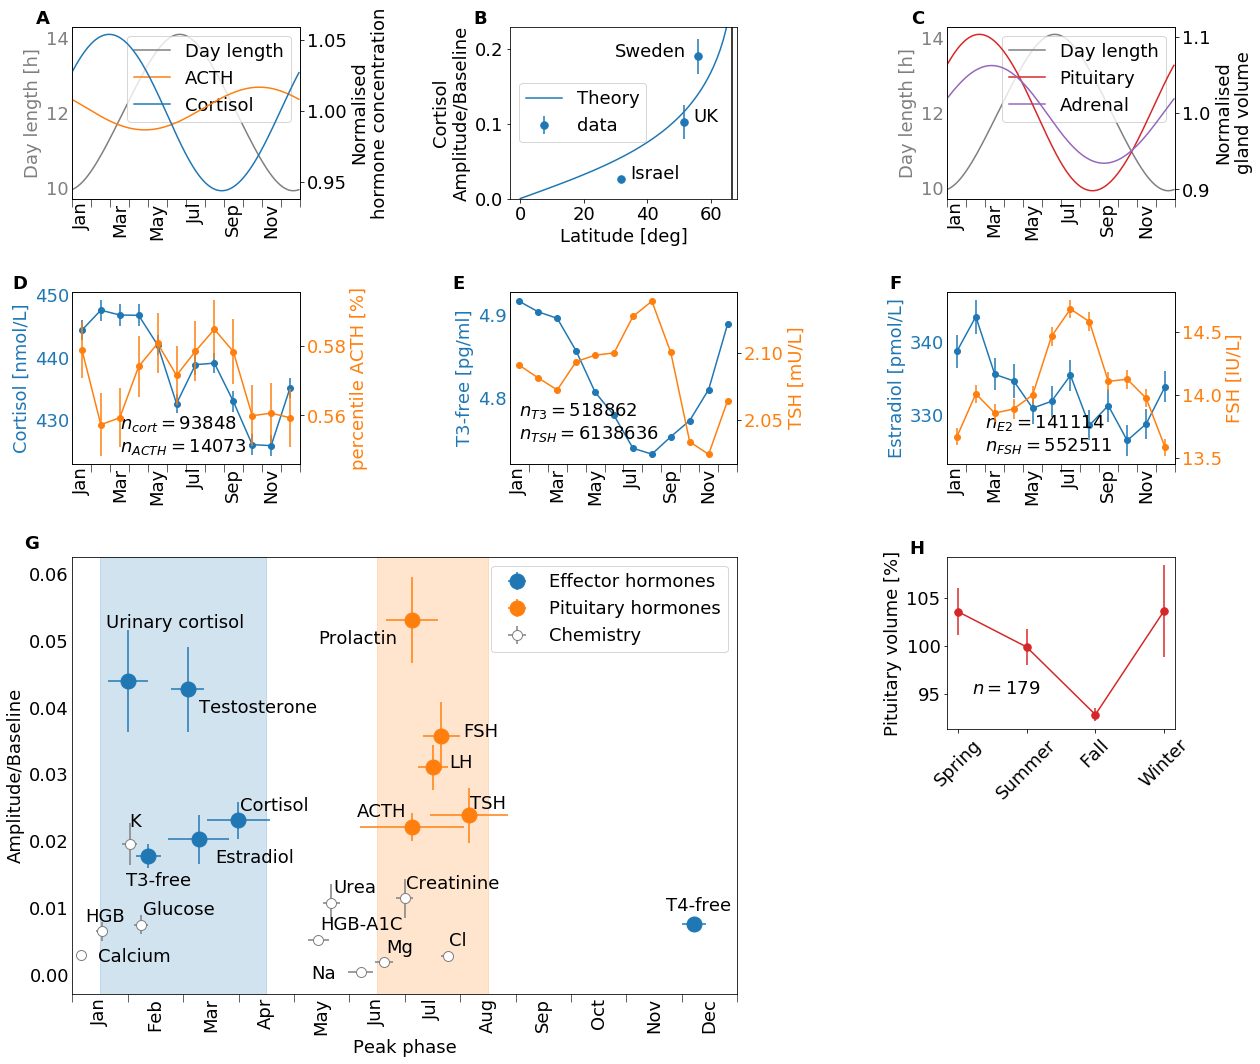

In [21]:
#This computes the seasonality figure in the main text (Fig 3 in 28.3.19 version of the manuscript)

fig,axes=plt.subplots(4,3, figsize=(18,15))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
gs=matplotlib.gridspec.GridSpec(4,3)


#############
#Cortisol ACTH theory
#############
def theory_two_scales(ax1, time, day_length, data1, data2, label1, label2, color1, color2):
    '''
    This function is used to plot effector and pituitary hormone together on a graph with two y-axes
    '''
    plt.sca(ax1)
    plt.xticks(0.5+np.arange(0,12,2),month_names[::2], rotation=45)
    ln1=ax1.plot(time,day_length,color=def_color[7])
    ax1.tick_params(axis='y', labelcolor=def_color[7])
    ax1.set_ylabel('Day length [h]',color=def_color[7])
    ax1.set_xlim([0,12])
    ax1.xaxis.set_major_locator(ticker.IndexLocator(base=2,offset=0.5))
    ax1.xaxis.set_minor_locator(ticker.IndexLocator(base=1,offset=0))
    ax1.set_xticklabels(month_names[::2], rotation=90)
    ax1.tick_params(which='minor', length=8)
    ax1.tick_params(which='major', length=0)
    
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ln2=ax2.plot(time,data1,linestyle='-',color=color1)
    ln3=ax2.plot(time,data2,linestyle='-',color=color2)
    ax2.set_ylabel('Normalised\nhormone concentration')
    ax1.legend(ln1+ln2+ln3,['Day length',label1,label2],loc=1)
    ax2.set_xlim([0,12])


    
    
phi=31.77#jerusalem
t=np.linspace(0,3*365-1,3*365)
day_length=daylen(31.77,delta=23.44*np.cos(2*np.pi*((t+10)/365))*np.pi/180)[:365]
sol=odeint(lambda y,t:AdrenalPituitaryEqsExact(y,t,timescale='day',phi=31.77),[1,1],t)
adrenal=sol[2*365:3*365,0]
pituitary=sol[2*365:3*365,1]
cortisol=adrenal**(1/3.)*pituitary**(1/3.)
ACTH=adrenal**(-2/3.)*pituitary**(1/3.)
    
    
ax1=axes[0][0]
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
theory_two_scales(ax1,np.arange(365)/365*12,day_length,ACTH,cortisol,'ACTH','Cortisol',def_color[1],def_color[0])  
    


#############
#Latitude
#############

ax1=axes[0][1]
ax1.text(-0.1, 1.1, 'B', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
plt.sca(ax1)

def get_scale(drift=13):
    arr=np.sin(2*np.pi/52*np.arange(52))
    arr_scale=np.convolve(arr,np.ones(drift))/drift
    return max(arr_scale)

def bootstrap_maxmin(data,nboots=1000):
    params=np.zeros(nboots)
    for i in range(nboots):
        inds=np.random.randint(0,12,12)
        rand_dat=data[inds]
        params[i]=(max(rand_dat)-min(rand_dat))/np.mean(rand_dat) 
    return np.mean(params),np.std(params)


phi_israel=31.77
#cort_path='../../data/Clalit/Netta/feb_19/seasonality.lab.101600.healthy_no_meds.csv'
cort_path='../data/Clalit_seasonality/seasonality.CORTISOL_BLOOD.healthy_no_medsraw.with_infection.0.05.20_80.csv'
cort_dat_both=get_seasonal_data(cort_path,'both')
cort_dat_female=get_seasonal_data(cort_path,'female')
cort_dat_male=get_seasonal_data(cort_path,'male')
cortisol_vals=np.array(cort_dat_both['mean'])
mean_israel,err_israel=bootstrap_maxmin(cortisol_vals)
#scale because of the 13 weeks change in dates
sc=get_scale()
mean_israel=mean_israel/sc
err_israel=err_israel/sc

phi_london=51.5
#Scale because the resolution is seasons and not months
t=np.linspace(0,3*365-1,3*365)
sol=odeint(lambda y,t:AdrenalPituitaryEqsExact(y,t,timescale='day',phi=phi_london),[1,1],t)
start_spring=365+90
end_spring=365+180
start_fall=2*365-180
end_fall=2*365-90
maxmin_london=max(sol[365:,0]**(1/3)*sol[365:,1]**(1/3))-min(sol[365:,0]**(1/3)*sol[365:,1]**(1/3))
seas_diff=np.mean(sol[start_spring:end_spring,1]**(1/3)*sol[start_spring:end_spring,0]**(1/3))\
-np.mean(sol[start_fall:end_fall,1]**(1/3)*sol[start_fall:end_fall,0]**(1/3))
print('maxmin',maxmin_london,'season diff',seas_diff)

#From circort paper
mean_london=0.111/(1-0.111/2)*maxmin_london/seas_diff
err_london=0.025/(1-0.111/2)*maxmin_london/seas_diff



#mean_london=0.111/(1-0.111/2)#*maxmin_london/seas_diff
#err_london=0.025/(1-0.111/2)#*maxmin_london/seas_diff



phi_sweden=55.9
import json
f=open('../data/sweden.json','rb')
sweden_dat=json.load(f)['datasetColl'][0]['data']
sweden_dat=np.array([x['value'][1] for x in sweden_dat])
mean_sweden,err_sweden=bootstrap_maxmin(sweden_dat)



phi=np.arange(k)

phi_dat=np.array([phi_israel,phi_london,phi_sweden])
mean_dat=np.array([mean_israel,mean_london,mean_sweden])
std_dat=np.array([err_israel,err_london,err_sweden])

#phi_dat=np.array([phi_israel,phi_london,phi_sweden])
#mean_dat=np.array([dat_israel,dat_london,mean_sweden])
#std_dat=np.array([err_israel,err_london,std_sweden])

plt.plot(phi,maxmin_res/2)
plt.errorbar(phi_dat,mean_dat/2,yerr=std_dat/2,marker='.',ls='none',markersize=15,color=def_color[0])
plt.legend(['Theory','data'],loc=6)
plt.axvline(x=66.55,color='black')
plt.xlabel('Latitude [deg]')
plt.ylabel('Cortisol\nAmplitude/Baseline')
plt.ylim([0,max(maxmin_res)/2])

ax1.annotate('Israel',(phi_israel+3,mean_israel/2))
ax1.annotate('UK',(phi_london+3,mean_london/2))
ax1.annotate('Sweden',(phi_sweden-26,mean_sweden/2))


#############
#Adrenal pituitary theory
#############

ax1=axes[0][2]
ax1.text(-0.1, 1.1, 'C', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
plt.sca(ax1)
plt.xticks(0.5+np.arange(0,12,2),month_names[::2], rotation=45)
ln1=ax1.plot(np.arange(365)/365*12,day_length,color=def_color[7])
ax1.tick_params(axis='y', labelcolor=def_color[7])
ax1.set_ylabel('Day length [h]',color=def_color[7])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ln2=ax2.plot(np.arange(365)/365*12,pituitary,linestyle='-',color=def_color[3])
ln3=ax2.plot(np.arange(365)/365*12,adrenal,linestyle='-',color=def_color[4])
ax2.set_ylabel('Normalised\ngland volume')
ax1.legend(ln1+ln2+ln3,['Day length','Pituitary','Adrenal'],loc=1)

ax1.set_xlim([0,12])
ax1.xaxis.set_major_locator(ticker.IndexLocator(base=2,offset=0.5))
ax1.xaxis.set_minor_locator(ticker.IndexLocator(base=1,offset=0))
ax1.set_xticklabels(month_names[::2], rotation=90)
ax1.tick_params(which='minor', length=8)
ax1.tick_params(which='major', length=0)









#############
#Cortisol data
#############


def two_scales(ax1, eff_data, pit_data, label1, label2):
    '''
    This function is used to plot effector and pituitary hormone together on a graph with two y-axes
    '''
    ax2 = ax1.twinx()
    
    ax1.errorbar(eff_data['month']-0.5,eff_data['mean'],yerr=eff_data['std']/eff_data['n']**0.5,color=def_color[0],marker='.',markersize=12)
    ax1.tick_params(axis='y', labelcolor=def_color[0])
    ax1.set_ylabel(label1,color=def_color[0])
    ax1.get_xticklabels()
    plt.sca(ax1)
    ax1.set_xlim([0,12])
    ax1.xaxis.set_major_locator(ticker.IndexLocator(base=2,offset=0))
    ax1.xaxis.set_minor_locator(ticker.IndexLocator(base=1,offset=0.5))
    ax1.set_xticklabels(month_names[::2], rotation=90)
    ax1.tick_params(which='minor', length=8)
    ax1.tick_params(which='major', length=0)
    #plt.xticks(1+np.arange(0,12,2),month_names[::2], rotation=45)

    ax2.errorbar(pit_data['month']-0.5,pit_data['mean'],yerr=pit_data['std']/pit_data['n']**0.5,linestyle='-',color=def_color[1],marker='.',markersize=12)
    ax2.tick_params(axis='y', labelcolor=def_color[1])
    ax2.set_ylabel(label2,color=def_color[1])

    

ACTH_path='../data/Clalit_seasonality/seasonality.ACTH_ADRENOCORTICOTROPIC_HORMONE.healthy_no_medsquantile.with_infection.0.05.20_80.csv'
cort_path='../data/Clalit_seasonality/seasonality.CORTISOL_BLOOD.healthy_no_medsraw.with_infection.0.05.20_80.csv'

ACTH_dat_both=get_seasonal_data(ACTH_path,'both')
cort_dat_both=get_seasonal_data(cort_path,'both')

ax1=axes[1][0]
ax1.text(-0.2, 1.1, 'D', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
two_scales(ax1,cort_dat_both,ACTH_dat_both,'Cortisol [nmol/L]','percentile ACTH [%]')

n_str_acth=str(sum(ACTH_dat_both['n']))
n_str_cort=str(sum(cort_dat_both['n']))
ax1.annotate('$n_{cort}='+n_str_cort+'$\n$n_{ACTH}='+n_str_acth+'$',(2.5,425))



#############
#Thyroid data
#############
#plt.subplot(4,3,5)


    



TSH_path='../data/Clalit_seasonality/seasonality.TSH_THYROID_STIMULATING_HORMONE.healthy_no_medsraw.with_infection.0.05.20_80.csv'
T3_path='../data/Clalit_seasonality/seasonality.T3_FREE.healthy_no_medsraw.with_infection.0.05.20_80.csv'

TSH_dat_both=get_seasonal_data(TSH_path,'both')
T3_dat_both=get_seasonal_data(T3_path,'both')

ax1=axes[1][1]
ax1.text(-0.2, 1.1, 'E', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
two_scales(ax1,T3_dat_both,TSH_dat_both,'T3-free [pg/ml]','TSH [mU/L]')

n_str_tsh=str(sum(TSH_dat_both['n']))
n_str_t3=str(sum(T3_dat_both['n']))
ax1.annotate('$n_{T3}='+n_str_t3+'$\n$n_{TSH}='+n_str_tsh+'$',(0.5,4.75))



#############
#Gonads data
#############

FSH_path='../data/Clalit_seasonality/seasonality.FSH_FOLLICLE_STIMULATING_HORMONE.healthy_no_medsraw.with_infection.0.05.20_80.csv'
est_path='../data/Clalit_seasonality/seasonality.ESTRADIOL_E_2.healthy_no_medsraw.with_infection.0.05.20_80.csv'

FSH_dat_female=get_seasonal_data(FSH_path,'female')
est_dat_female=get_seasonal_data(est_path,'female')

ax1=axes[1][2]
ax1.text(-0.2, 1.1, 'F', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
two_scales(ax1,est_dat_female,FSH_dat_female,'Estradiol [pmol/L]','FSH [IU/L]')

n_str_fsh=str(sum(FSH_dat_female['n']))
n_str_est=str(sum(est_dat_female['n']))
ax1.annotate('$n_{E2}='+n_str_est+'$\n$n_{FSH}='+n_str_fsh+'$',(2,325))




#############
#Large hormone seasonality plot
#############

#gs=axes[2,0].get_gridspec()
axes[2][0].remove()
axes[3][0].remove()
axes[2][1].remove()
axes[3][1].remove()
axbig=fig.add_subplot(gs[2:4,0:2])
axbig.text(-0.05, 1.05, 'G', transform=axbig.transAxes, fontweight='bold', va='top', ha='right')


plt.sca(axbig)    


def plot_phase_amp(ax,amp_mean,phase_mean,amp_std,phase_std,names,color=def_color[0],loc_list=None,markersize=30,empty=False):
    if empty:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize,fmt='o', mfc='white')
    else:
        ax.errorbar(phase_mean, amp_mean,ls='none',marker='.',xerr=phase_std,yerr=amp_std,color=color,markersize=markersize)
    if loc_list==None:
        loc_list=len(phase_mean)*[(0.015,0.001)]
    for i, txt in enumerate(names):   
        ax.annotate(txt, (phase_mean[i]+loc_list[i][0], amp_mean[i]+loc_list[i][1]))

#dictionaries of lab tests
pituitary_hormone_loc={'ACTH_ADRENOCORTICOTROPIC_HORMONE':(-1,0.003/2),
                    'TSH_THYROID_STIMULATING_HORMONE':(0.02,0.002/2),
                    #'GROWTH_HORMONE_GH':'GH',
                    'LH_LUTEINIZING_HORMONE':(0.3,0),
                    'FSH_FOLLICLE_STIMULATING_HORMONE':(0.4,0),                   
                    'PROLACTIN':(-1.7,-0.007/2)}

effector_hormone_loc={ 'CORTISOL_BLOOD':(0.03,0.003/2),
 'CORTISOL_U_FREE_24h':(-0.4,0.016/2),
 'T3_FREE':(-0.4,-0.009/2),
 'T4_FREE':(-0.5,0.004/2),
 #'INSULIN_LIKE_GROWTH_FACTOR_1':'IGF-1',
 'ESTRADIOL_E_2':(0.3,-0.007/2),
 #'PROGESTERONE':'Progesterone',
 'TESTOSTERONE_TOTAL':(0.2,-0.007/2)}

chem_loc={
 'CALCIUM_BLOOD':(0.3,-0.002/2),
 'CREATININE_BLOOD':(0.03,0.003/2),
 'Cl':(0.03,0.003/2),
 'GLUCOSE_BLOOD':(0.03,0.003/2),
 'HEMOGLOBIN_A1C_CALCULATED':(0.03,0.003/2),
 'HGB':(-0.3,0.003/2),
 'MAGNESIUM_BLOOD':(0.03,0.003/2),
 'POTASSIUM':(0,0.005/2),
 'SODIUM':(-0.9,-0.002/2),
 'UREA_BLOOD':(0.03,0.003/2)}
        
#TSH phase by max rather than cosinor
pituitary_phase_mean_TSH=np.copy(pituitary_phase_mean)
pituitary_phase_mean_TSH[1]=pituitary_max_phase_mean[1]
pituitary_phase_std_TSH=np.copy(pituitary_phase_std)
pituitary_phase_std_TSH[1]=pituitary_max_phase_std[1]
plot_phase_amp(axbig,np.array(effector_amp_mean)/2,effector_phase_mean,np.array(effector_amp_std)/2,effector_phase_std,effector_names,color=def_color[0],loc_list=list(effector_hormone_loc.values()))
plot_phase_amp(axbig,np.array(pituitary_amp_mean)/2,pituitary_phase_mean_TSH,np.array(pituitary_amp_std)/2,pituitary_phase_std_TSH,pituitary_names,color=def_color[1],loc_list=list(pituitary_hormone_loc.values()))
plot_phase_amp(axbig,np.array(chem_amp_mean)/2,chem_phase_mean,chem_amp_std,np.array(chem_phase_std)/2,chem_names,color=def_color[7],loc_list=list(chem_loc.values()),markersize=20,empty=True)

#plot_phase_amp(axbig,effector_amp_mean,effector_phase_mean,effector_amp_std,effector_phase_std,effector_names,color=def_color[0],loc_list=list(effector_hormone_loc.values()))
#plot_phase_amp(axbig,pituitary_amp_mean,pituitary_phase_mean,pituitary_amp_std,pituitary_phase_std,pituitary_names,color=def_color[1],loc_list=list(pituitary_hormone_loc.values()))
#plot_phase_amp(axbig,chem_amp_mean,chem_phase_mean,chem_amp_std,chem_phase_std,chem_names,color=def_color[7],loc_list=list(chem_loc.values()),markersize=20,empty=True)

#plot_phase_amp(axbig,effector_amp_mean,effector_max_phase_mean,effector_amp_std,effector_max_phase_std,effector_names,color=def_color[0],loc_list=list(effector_hormone_loc.values()))
#plot_phase_amp(axbig,pituitary_amp_mean,pituitary_max_phase_mean,pituitary_amp_std,pituitary_max_phase_std,pituitary_names,color=def_color[1],loc_list=list(pituitary_hormone_loc.values()))
#plot_phase_amp(axbig,chem_amp_mean,chem_max_phase_mean,chem_amp_std,chem_max_phase_std,chem_names,color=def_color[7],loc_list=list(chem_loc.values()),markersize=20)

plt.legend(['Effector hormones','Pituitary hormones','Chemistry'],loc=1)#,bbox_to_anchor=(1,0.83))
plt.plot(0,0,'w')
axbig.set_xlim([0,12])
axbig.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0.5))
axbig.xaxis.set_minor_locator(ticker.IndexLocator(base=1,offset=0))
axbig.set_xticklabels(month_names, rotation=90)
axbig.tick_params(which='minor', length=8)
axbig.tick_params(which='major', length=0)

#axbig.set_xticks(0.5+np.arange(12))
#axbig.set_xticklabels(month_names, rotation=45)
plt.ylabel('Amplitude/Baseline')
plt.xlabel('Peak phase')

axbig.axvspan(0.5, 3.5, alpha=0.2, color=def_color[0])
axbig.axvspan(5.5, 7.5, alpha=0.2, color=def_color[1])
#patch1=matplotlib.patches.Rectangle((0.5,0.03),3,0.07,alpha=0.2,color=def_color[0])
#axbig.add_patch(patch1)
#patch2=matplotlib.patches.Rectangle((5,0.04),2,0.07,alpha=0.2,color=def_color[1])
#axbig.add_patch(patch2)

#patch1=matplotlib.patches.Rectangle((0.2,0.03),2.5,0.07,alpha=0.2,color=def_color[0])
#axbig.add_patch(patch1)
#patch2=matplotlib.patches.Rectangle((6,0.04),2,0.07,alpha=0.2,color=def_color[1])
#axbig.add_patch(patch2)

axbig.set_xlim([0,12])



#############
#Pituitary data plot
#############

ax1=axes[2][2]
ax1.text(-0.1, 1.1, 'H', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')


plt.sca(ax1)

pituitary_table=pd.read_excel('../data/Pituitary_HCP.xlsx')

norm_mean=np.array(pituitary_table['nomalized mean']/np.mean(pituitary_table['nomalized mean']))
norm_std=np.array(pituitary_table['nomalized mean']/np.mean(pituitary_table['nomalized mean']))

winter_mean=np.mean(norm_mean[[0,10,11]])
winter_std=np.std(norm_std[[0,10,11]])/3**0.5

spring_mean=np.mean(norm_mean[1:4])
spring_std=np.std(norm_std[1:4])/3**0.5
summer_mean=np.mean(norm_mean[4:7])
summer_std=np.std(norm_std[4:7])/3**0.5
fall_mean=np.mean(norm_mean[7:10])
fall_std=np.std(norm_std[7:10])/3**0.5

season_mean=100*np.array([spring_mean,summer_mean,fall_mean,winter_mean])
season_std=100*np.array([spring_std,summer_std,fall_std,winter_std])
plt.errorbar([0,1,2,3],season_mean,yerr=season_std,marker='.',color=def_color[3],markersize=15)

plt.xticks([0,1,2,3],['Spring','Summer','Fall','Winter'], rotation=45)

plt.ylabel('Pituitary volume [%]')

ax1.annotate('$n=179$',(0.2,95))

#############
#Last empty subplot
#############
axes[3][2].remove()




plt.tight_layout()
plt.savefig('../figures/seasonality.pdf',bbox_inches='tight',dpi=600)
plt.show()



In [22]:
#This part of code computes the consinor tables in the SI

def get_cosinor_table(test_dic):
    '''
    Compute bootstrap of cosinor results for list of lab tests from an input dictionary
    '''
    all_tests_maxmin=[]
    all_tests_rel_maxmin=[]
    all_tests_phase=[]
    all_tests_amp=[]
    all_tests_mesor=[]
    all_tests_n=[]
    p_val_phase=[]
    names=[]
    #The path to search for the hormones
    path='../data/Clalit_seasonality/seasonality.*.healthy_no_medsraw.with_infection.0.05.20_80.csv'
    for k in test_dic.keys():
        try:
            dat=get_seasonal_data(path.replace('*',str(k)),'both')
            if sum(dat['n'])>1000:
                boots_mat=bootstrap_months_cosinor(dat,nboots=1000)
                all_tests_n.append(sum(dat['n']))
                all_tests_phase.append(get_phase(boots_mat))
                all_tests_rel_maxmin.append(get_relative_amp(boots_mat))
                all_tests_amp.append(get_abs_amp(boots_mat))
                all_tests_mesor.append(get_mesor(boots_mat))
                all_tests_maxmin.append(get_maxmin(boots_mat))
                p_val_phase.append(get_phase_pval(boots_mat))
                names.append(test_dic[k])
        except:
           print('error')
    #normalize phase back to months
    #phase_mean=[np.mod(12/(2*np.pi)*(-x[0]+2*np.pi*10/365),12) for x in all_tests_phase]
    phase_mean=[np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase]
    phase_std=[12/(2*np.pi)*x[1] for x in all_tests_phase]
    all_tests_phase=[(phase_mean[i],phase_std[i]) for i in range(len(phase_mean))] 
    return names,all_tests_n,all_tests_mesor,all_tests_amp,all_tests_maxmin,all_tests_rel_maxmin,all_tests_phase,p_val_phase



chem_table=get_cosinor_table(chem_dic)
pituitary_table=get_cosinor_table(pituitary_hormone_dic)
effector_table=get_cosinor_table(effector_hormone_dic)

def print_cosinor_table(table):
    for i in range(len(table[0])):
        print('name',table[0][i],'n',table[1][i],'mesor',table[2][i],'amplitude',table[3][i],'max-min',table[4][i],'relative max-min',table[5][i],'phase',table[6][i],'p-val',table[7][i])

print_cosinor_table(chem_table)
print('**************************')
print_cosinor_table(pituitary_table)
print('**************************')
print_cosinor_table(effector_table)


error
name Calcium n 6977294 mesor (9.41612962036964, 0.006052896162193954) amplitude (0.026658831132615437, 0.0028029386613359964) max-min (0.053320862022694926, 0.002662037649970352) relative max-min (0.0056627205642468615, 0.0002827730475672919) phase (0.49280905766829286, 0.2448680848649336) p-val 0.007
name Creatinine n 11787979 mesor (0.8004781652529296, 0.0018254190765532895) amplitude (0.007801639435820821, 0.0012151057839540464) max-min (0.017731393991383362, 0.002474960805438232) relative max-min (0.022153721322724394, 0.0031081804765157044) phase (6.379106544715498, 0.3399071415077262) p-val 0.0
name Cl n 1707071 mesor (103.53929384484034, 0.05529964361092765) amplitude (0.2416267711241734, 0.03548042376121612) max-min (0.5638109138228704, 0.07948022991372265) relative max-min (0.005445404283626105, 0.0007678583882298479) phase (7.11547645061985, 0.2756916357907315) p-val 0.0
name Glucose n 8918119 mesor (91.00386561700756, 0.14754036324979927) amplitude (0.6400942482442264,

In [23]:
#Seasonality data utils

from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import r2_score


pituitary_hormones={#'ACTH_ADRENOCORTICOTROPIC_HORMONE':'ACTH [pmol/L]',
                    'TSH_THYROID_STIMULATING_HORMONE':'TSH [mIU/L]',
                    'LH_LUTEINIZING_HORMONE':'LH [IU/I]',
                    'FSH_FOLLICLE_STIMULATING_HORMONE':'FSH [IU/I]',                   
                    'PROLACTIN':'Prolactin [mIU/L]'}

effector_hormones={ 'CORTISOL_BLOOD':'Cortisol [nmol/L]',
 'CORTISOL_U_FREE_24h':'Urinary cortisol [nmol/24hr]',
 'T3_FREE':'T3-free [pmol/L]',
 'T4_FREE':'T4-free [pmol/L]',
 'ESTRADIOL_E_2':'Estradiol [pmol/L]',
 #'PROGESTERONE':'Progesterone [nmol/L]',
 'TESTOSTERONE_TOTAL':'Testosterone [nmol/L]'}

chemistry={
 'CALCIUM_BLOOD':'Calcium [mg/dL]',
 'CREATININE_BLOOD':'Creatinine [mg/dL]',
 'Cl':'Cl [mEq/L]',
 'GLUCOSE_BLOOD':'Glucose [mg/dL]',
 'HEMOGLOBIN_A1C_CALCULATED':'HGB-A1C',
 'HGB':'HGB [g/dL]',
 'MAGNESIUM_BLOOD':'Mg [mg/dL]',
 'POTASSIUM':'K [mEq/L]',
 'SODIUM':'Na [mEq/L]',
 'UREA_BLOOD':'Urea [mg/dL]'}

path='../data/Clalit_seasonality/*.csv'
files=glob.glob(path)

def filter_files(files,measure_type='seasonality',hormone=None,percentile_type='healthy_no_medsraw',\
                infection_type='with_infection',percent_discard='0.05',ages='20_80'):
    '''
    measure_type can be seasonality or pregnancy
    hormone can be any hormone from the list
    percentile_type can be allquantile, allraw, healthy_no_medsquantile or, healthy_no_medsraw 
    infection_type can be with_infection or no_infection
    percent_discard can be 0.01,0.05 or 0.1
    ages can be 20_30_40_50_60_70_80, 20_40_60_80 or 20_80
    '''
    files=[x for x in files if x.split('/')[-1].split('.')[0]==measure_type]
    if hormone!=None:
        files=[x for x in files if x.split('/')[-1].split('.')[1]==hormone]
    if measure_type=='seasonality':
        files=[x for x in files if x.split('/')[-1].split('.')[-6]==percentile_type]
        files=[x for x in files if x.split('/')[-1].split('.')[-5]==infection_type]
        files=[x for x in files if x.split('/')[-1].split('.')[-3]==percent_discard[2:]]
        files=[x for x in files if x.split('/')[-1].split('.')[-2]==ages]
    return files

def get_seasonal_data(file_path,gender='both'):
    dat=pd.read_csv(file_path)
    if gender=='female':
        return dat[(dat['type']=='female')]
    if gender=='male':
        return dat[(dat['type']=='male')]
    return dat[(dat['type']=='both')]

def plot_dat(df_dat,ax,ylab='ylabel here',color=def_color[0],linestyle='-',text_loc=[0.1,0.1],alpha=1):
    ax.errorbar(df_dat['month']-0.5,df_dat['mean'],yerr=df_dat['std']/df_dat['n']**0.5,linestyle=linestyle,marker='.',markersize=12,color=color,alpha=alpha)
    ax.set_xlim([0,12])
    ax.xaxis.set_major_locator(ticker.IndexLocator(base=1,offset=0))
    ax.xaxis.set_minor_locator(ticker.IndexLocator(base=1,offset=0.5))
    ax.set_xticklabels(month_names, rotation=45)
    ax.tick_params(which='minor', length=8)
    ax.tick_params(which='major', length=0)
    #ax.set_xticks(1+np.arange(12))
    #ax.set_xticklabels(month_names, rotation=45)
    ax.set_ylabel(ylab)
    if text_loc!=None:
        n_str='$n = '+str(sum(df_dat['n']))+'$'
        ax.text(text_loc[0],text_loc[1],n_str,transform=ax.transAxes)


def plot_files(files):
    k=len(files)
    fig=plt.figure(figsize=(16, 5*k))
    for i in range(k):
        female_dat=get_seasonal_data(files[i],'female')
        ax=fig.add_subplot(k,3,3*i+1)
        plot_dat(female_dat,ax,ylab=files[i].split('/')[-1].split('.')[1])
        
        male_dat=get_seasonal_data(files[i],'male')
        ax=fig.add_subplot(k,3,3*i+2)
        plot_dat(male_dat,ax,ylab=files[i].split('/')[-1].split('.')[1])
        
        both_dat=get_seasonal_data(files[i],'both')
        ax=fig.add_subplot(k,3,3*i+3)
        plot_dat(both_dat,ax,ylab=files[i].split('/')[-1].split('.')[1])
        

def goodness_cosinor(xdat,ydat):
    M=np.mean(ydat)#mesor
    ydat=ydat-M
    st=np.std(ydat)
    maxamp=np.max(abs(ydat))
    res_fit=curve_fit(lambda x,A,phi:A*np.cos(x+phi),xdat,ydat,p0=[st,0],bounds=[(maxamp/20,-np.pi),(maxamp,np.pi)])
    A=res_fit[0][0]
    phi=res_fit[0][1]
    #return np.corrcoef(A*np.cos(xdat+phi),ydat)[0,1]
    ypred = A*np.cos(xdat+phi)
    SST = sum((ydat - 0)**2)
    SSReg = sum((ypred - 0)**2)
    Rsquared = SSReg/SST
    return Rsquared
    return r2_score(A*np.cos(xdat+phi),ydat)
    
def plot_cosinor_fit(dat,ax):
    boots_mat=bootstrap_months_cosinor(dat,nboots=100)
    mesor=np.mean(boots_mat[:,0])
    amp=np.mean(boots_mat[:,1])
    phase=circmean(boots_mat[:,2],high=np.pi, low=-np.pi)
    xdat,ydat=data2xy(dat)
    fit_goodness=goodness_cosinor(xdat,ydat)
    t=np.arange(1,13)
    #ax.plot(t,params[0]+params[1]*np.cos(2*np.pi*((t-1)/12+25/365)+params[2]),color='gray')
    ax.plot(t,mesor+amp*np.cos(xdat+phase),color='gray')
    atext=AnchoredText('$R^2=$'+str(fit_goodness)[:4],loc=2)
    ax.add_artist(atext)
    
    
def plot_dict(test_dict,files,fig=None,percentile_type='healthy_no_medsraw',\
                infection_type='with_infection',percent_discard='0.05',\
              linestyle='-',color=def_color[0],text_loc=[0.1,0.1],alpha=1,cosinor_fit=False):
    n=len(test_dict)
    if fig==None:
        fig=plt.figure(figsize=(16, 5*n))
    filtered_files=[]
    for i,k in enumerate(test_dict.keys()):
        hormone_file=filter_files(files,hormone=k,percentile_type=percentile_type,\
                                   infection_type=infection_type,percent_discard=percent_discard)[0]
        female_dat=get_seasonal_data(hormone_file,'female')
        ax=fig.add_subplot(n,3,3*i+1)
        plot_dat(female_dat,ax,ylab='Women\n'+test_dict[k],\
                linestyle=linestyle,color=color,text_loc=text_loc,alpha=alpha)
        if cosinor_fit:
             plot_cosinor_fit(female_dat,ax)   
        
        ax.text(-0.05, 1.15, chr(ord('A')+i), transform=ax.transAxes, fontweight='bold', va='top', ha='right')


        male_dat=get_seasonal_data(hormone_file,'male')
        ax=fig.add_subplot(n,3,3*i+2)
        plot_dat(male_dat,ax,ylab='Men\n'+test_dict[k],\
                 linestyle=linestyle,color=color,text_loc=text_loc,alpha=alpha)
        if cosinor_fit:
            plot_cosinor_fit(male_dat,ax) 
            
        both_dat=get_seasonal_data(hormone_file,'both')
        ax=fig.add_subplot(n,3,3*i+3)
        plot_dat(both_dat,ax,ylab=test_dict[k],\
                 linestyle=linestyle,color=color,text_loc=text_loc,alpha=alpha)
        if cosinor_fit:
            plot_cosinor_fit(both_dat,ax) 

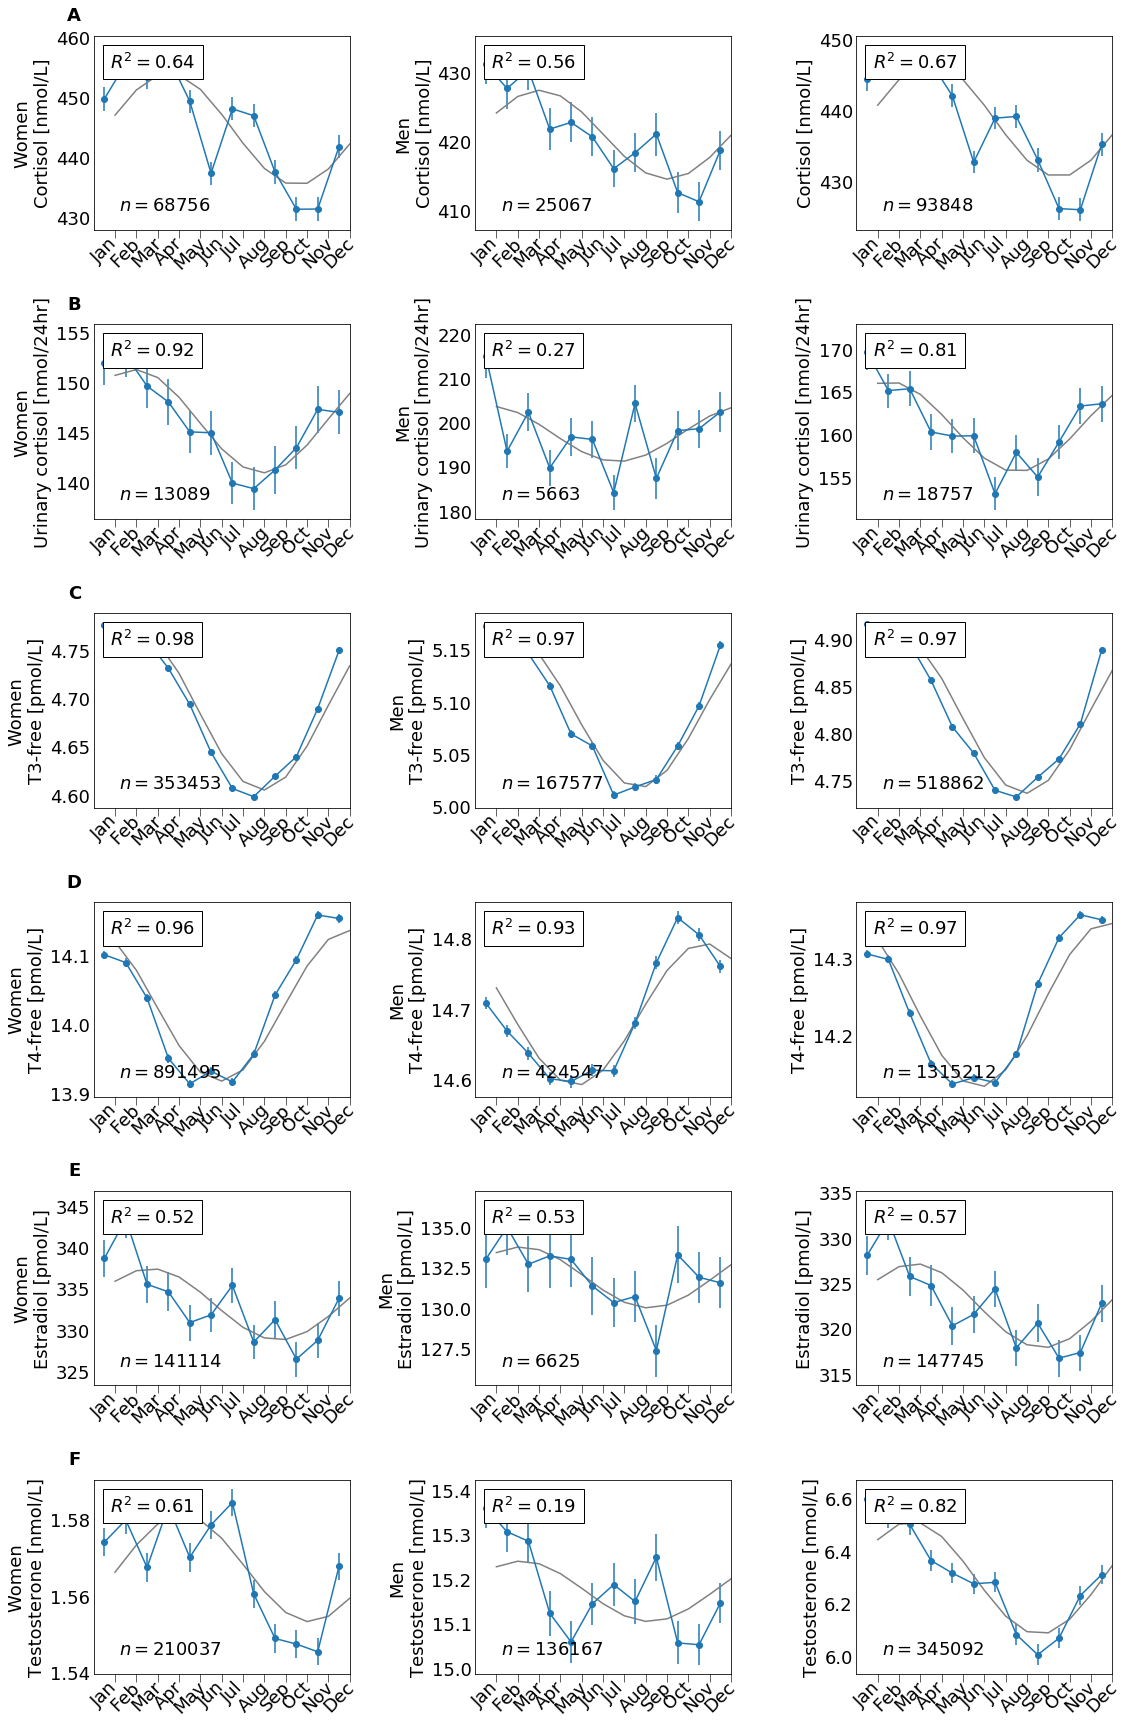

In [24]:
# Plot of effector all hormone

fig=plt.figure(figsize=(16, 4*len(effector_hormones)))
#plot_dict(effector_hormones,files,fig=fig,percentile_type='healthy_no_medsraw',\
#          percent_discard='0.05',infection_type='no_infection',color=def_color[0],alpha=0.3,text_loc=None)

plot_dict(effector_hormones,files,fig=fig,percentile_type='healthy_no_medsraw',\
          percent_discard='0.05',infection_type='with_infection',color=def_color[0],cosinor_fit=True)
#percentile_type can be allquantile, allraw, healthy_no_medsquantile or, healthy_no_medsraw 

plt.tight_layout()
plt.savefig('../figures/S2_Effector_fit.pdf',bbox_inches='tight',dpi=600)


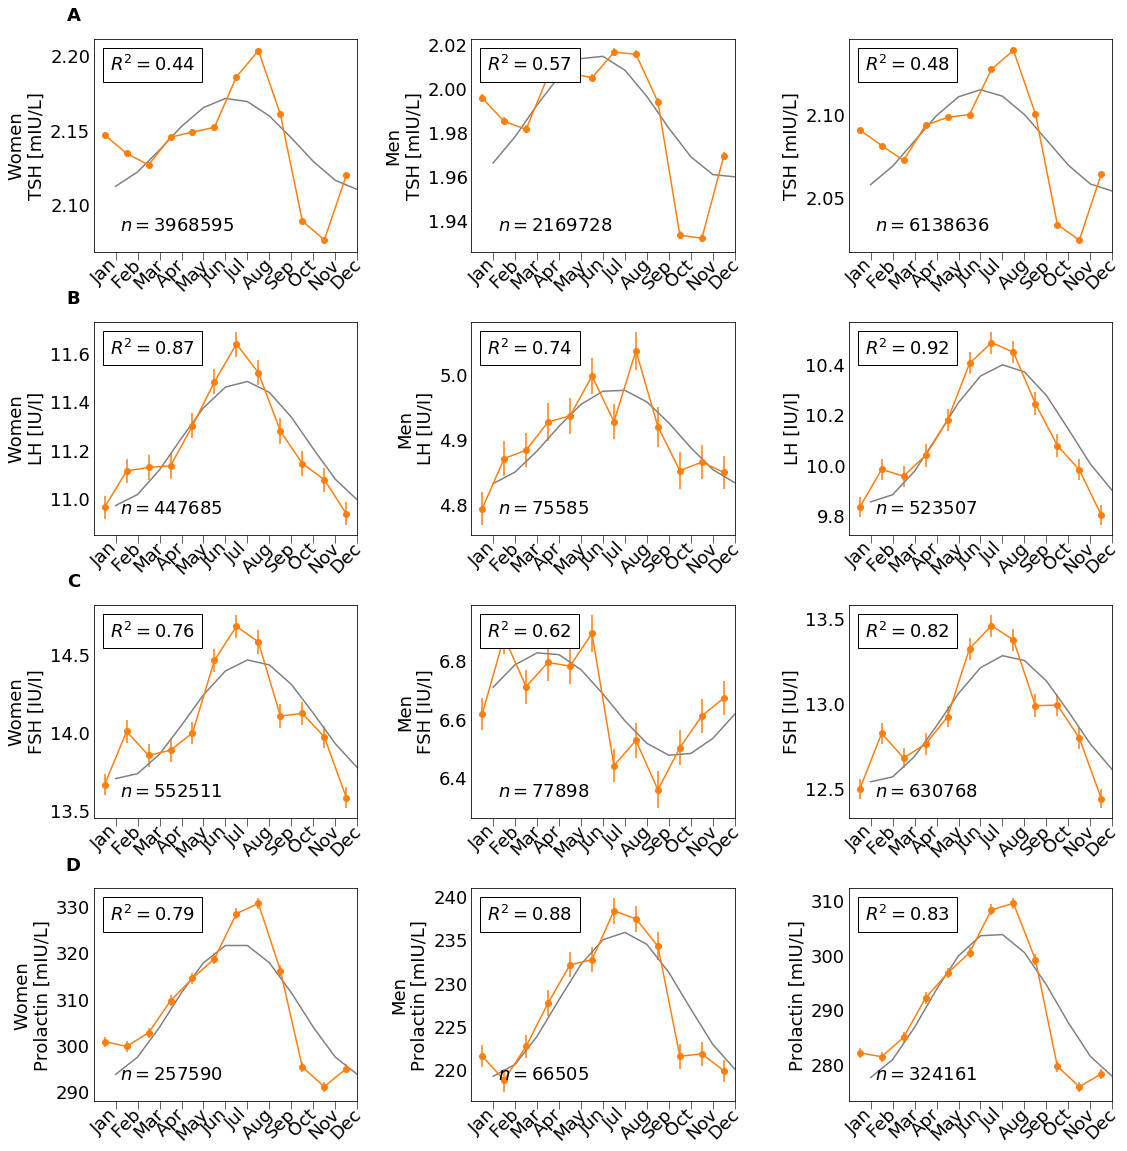

In [25]:
# Plot of effector all hormone

fig=plt.figure(figsize=(16, 4*len(pituitary_hormones)))
#plot_dict(pituitary_hormones,files,fig=fig,percentile_type='healthy_no_medsraw',\
#          percent_discard='0.05',infection_type='no_infection',color=def_color[1],text_loc=None,linestyle='-',alpha=0.5)



plot_dict(pituitary_hormones,files,fig=fig,percentile_type='healthy_no_medsraw',\
          percent_discard='0.05',infection_type='with_infection',color=def_color[1],linestyle='-',cosinor_fit=True)
#percentile_type can be allquantile, allraw, healthy_no_medsquantile or, healthy_no_medsraw 

plt.tight_layout()
plt.savefig('../figures/S3_Pituitary_fit.pdf',bbox_inches='tight',dpi=600)

#no ACTH,GH, progesterone

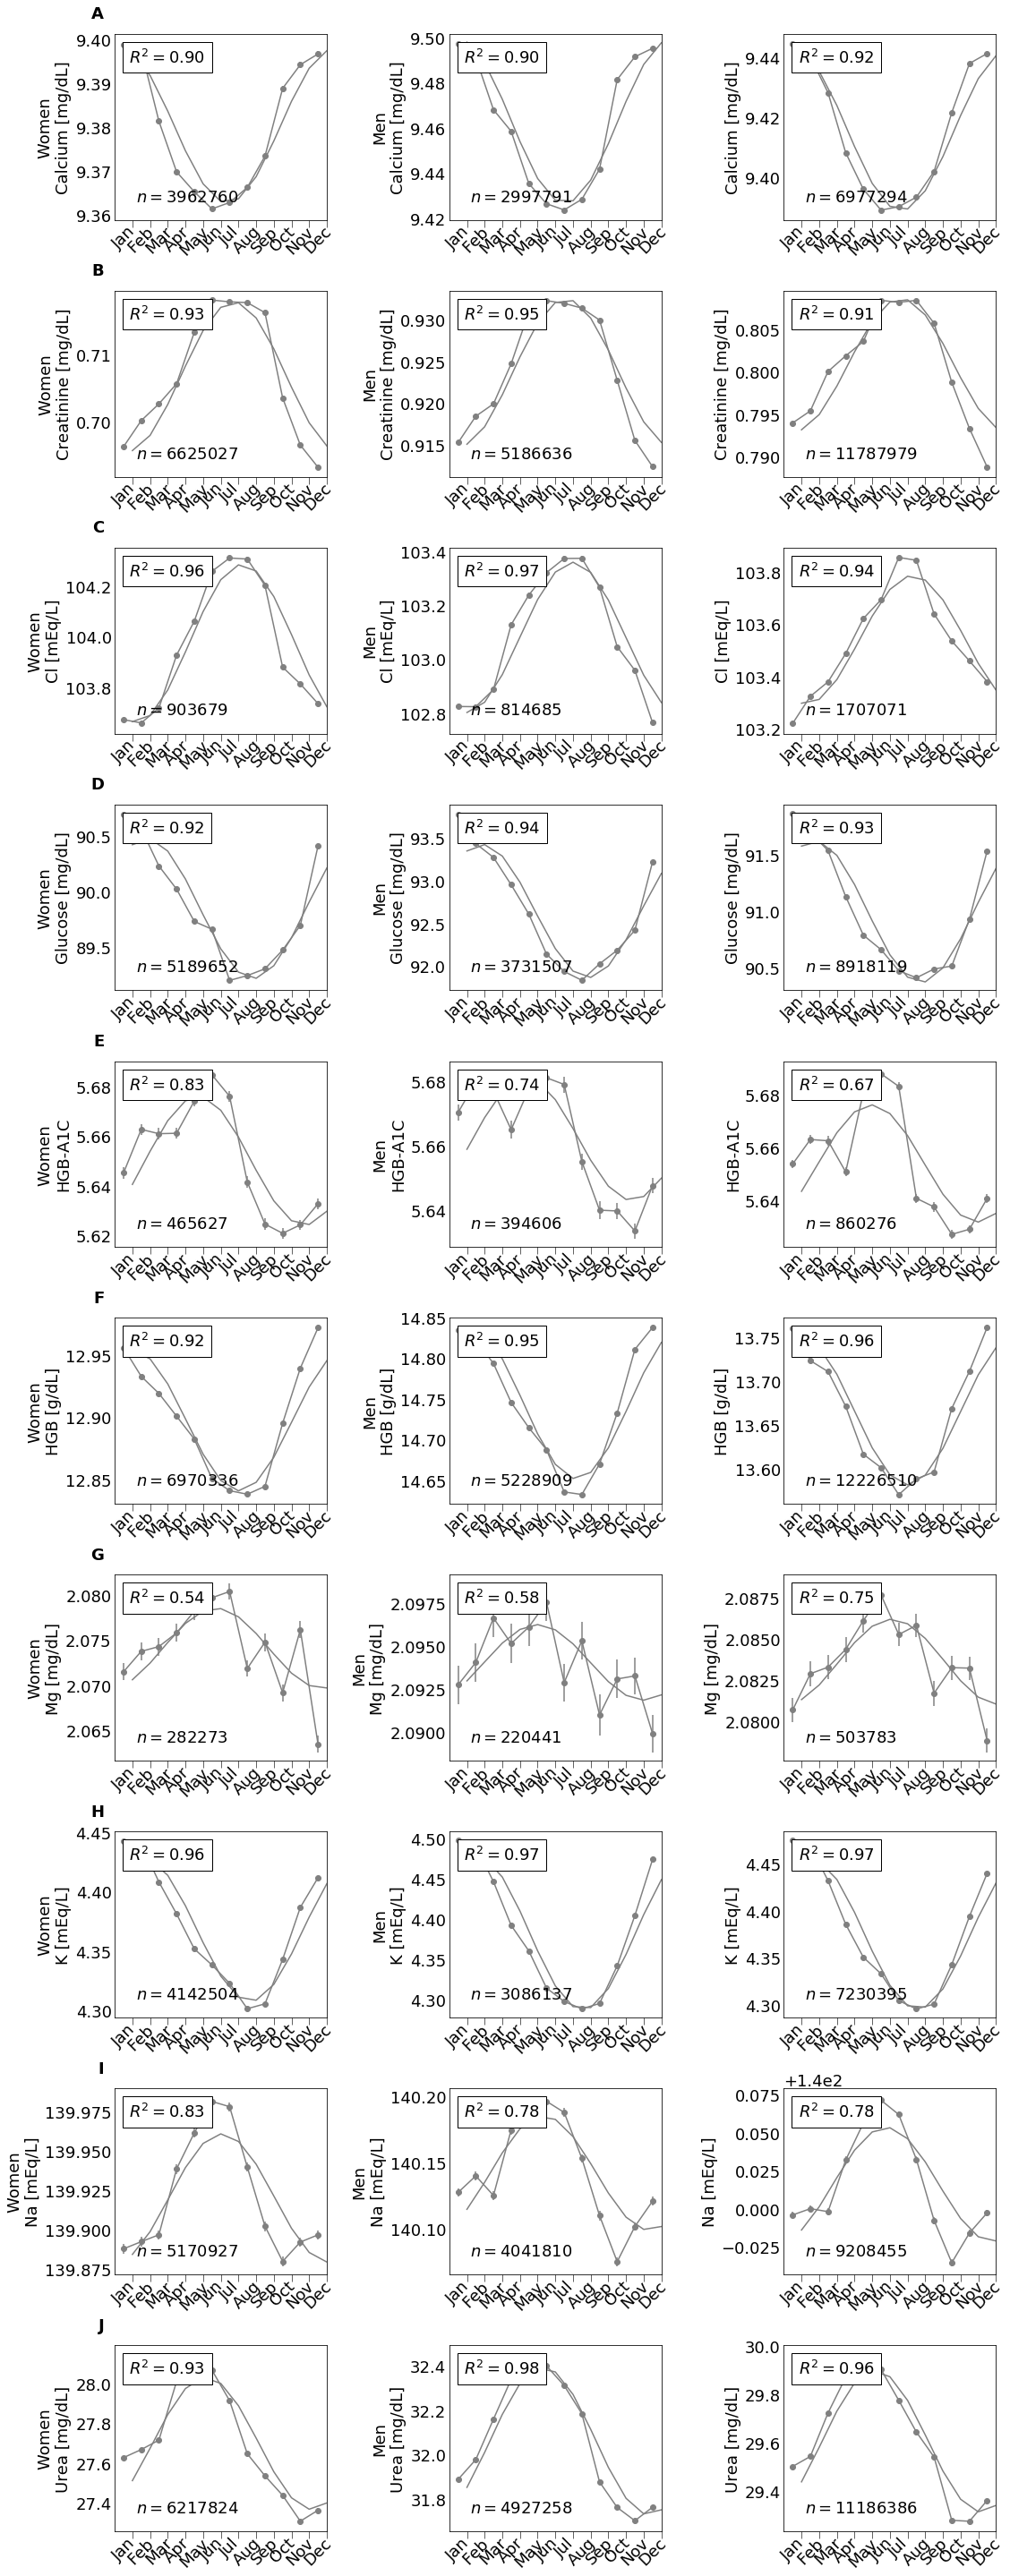

In [26]:
# Plot of chemistry

fig=plt.figure(figsize=(16, 4*len(chemistry)))
#plot_dict(chemistry,files,fig=fig,percentile_type='allraw',\
#          percent_discard='0.05',infection_type='with_infection',color='black',text_loc=None,alpha=0.2)



plot_dict(chemistry,files,fig=fig,percentile_type='healthy_no_medsraw',\
          percent_discard='0.05',infection_type='with_infection',color='gray',cosinor_fit=True)
#percentile_type can be allquantile, allraw, healthy_no_medsquantile or, healthy_no_medsraw 

plt.tight_layout()
plt.savefig('../figures/S4_Chemistry_fit.pdf',dpi=600)



/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


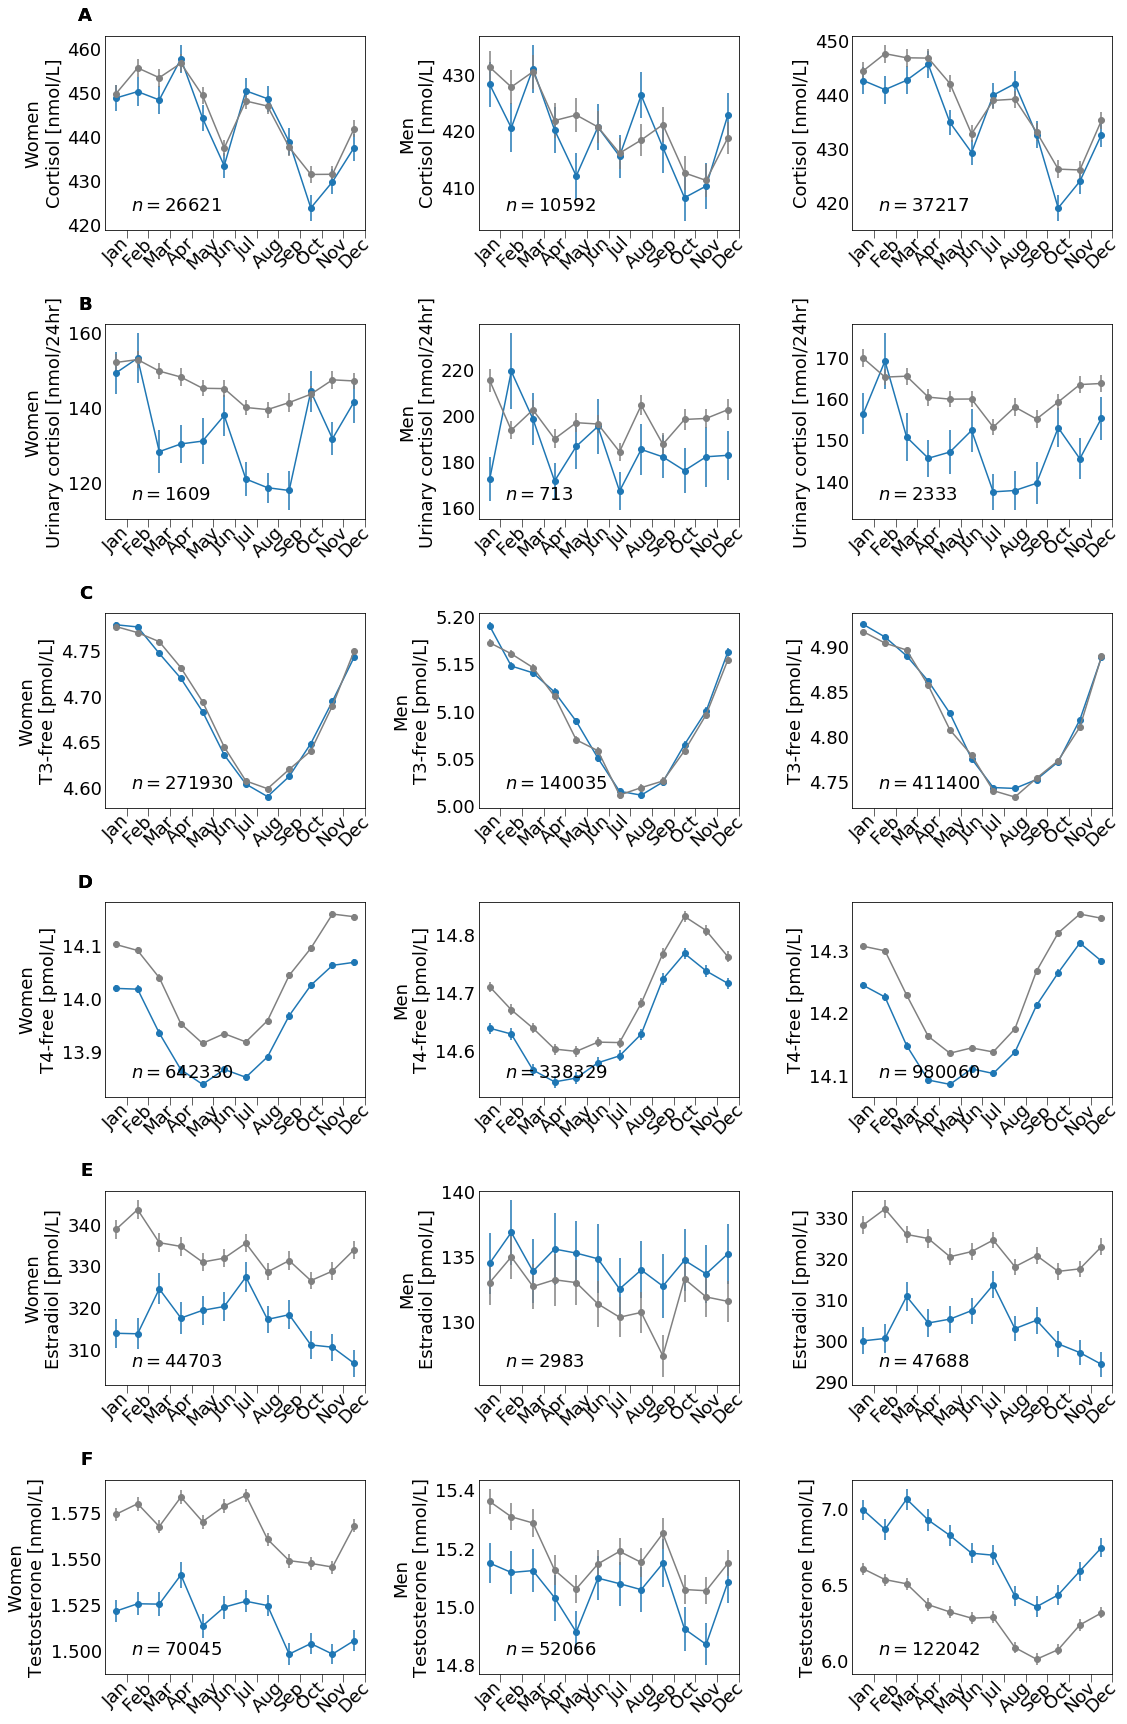

In [27]:
# Plot of effector all hormone

fig=plt.figure(figsize=(16, 4*len(effector_hormones)))
plot_dict(effector_hormones,files,fig=fig,percentile_type='healthy_no_medsraw',\
          percent_discard='0.05',infection_type='no_infection',color=def_color[0])

plot_dict(effector_hormones,files,fig=fig,percentile_type='healthy_no_medsraw',\
          percent_discard='0.05',infection_type='with_infection',color='gray',text_loc=None)
#percentile_type can be allquantile, allraw, healthy_no_medsquantile or, healthy_no_medsraw 

plt.tight_layout()
plt.savefig('../figures/Effector_infection.pdf',bbox_inches='tight',dpi=600)



/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


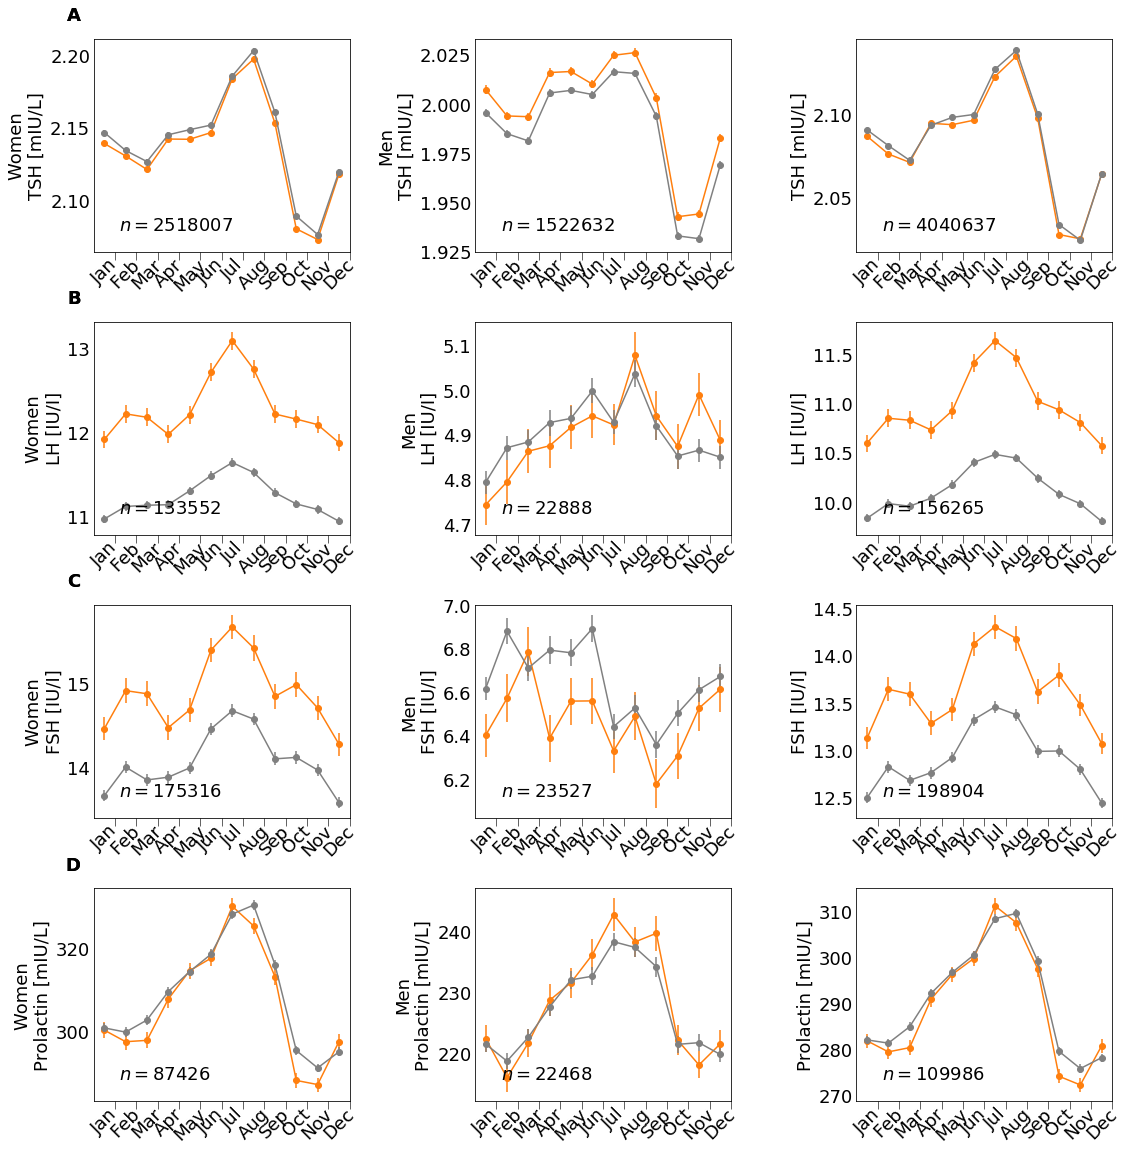

In [28]:
#plot of pituitary hormones

fig=plt.figure(figsize=(16, 4*len(pituitary_hormones)))
plot_dict(pituitary_hormones,files,fig=fig,percentile_type='healthy_no_medsraw',\
          percent_discard='0.05',infection_type='no_infection',color=def_color[1])

plot_dict(pituitary_hormones,files,fig=fig,percentile_type='healthy_no_medsraw',\
          percent_discard='0.05',infection_type='with_infection',color='gray',text_loc=None)
#percentile_type can be allquantile, allraw, healthy_no_medsquantile or, healthy_no_medsraw 

plt.tight_layout()
plt.savefig('../figures/Pituitary_infection.pdf',bbox_inches='tight',dpi=600)


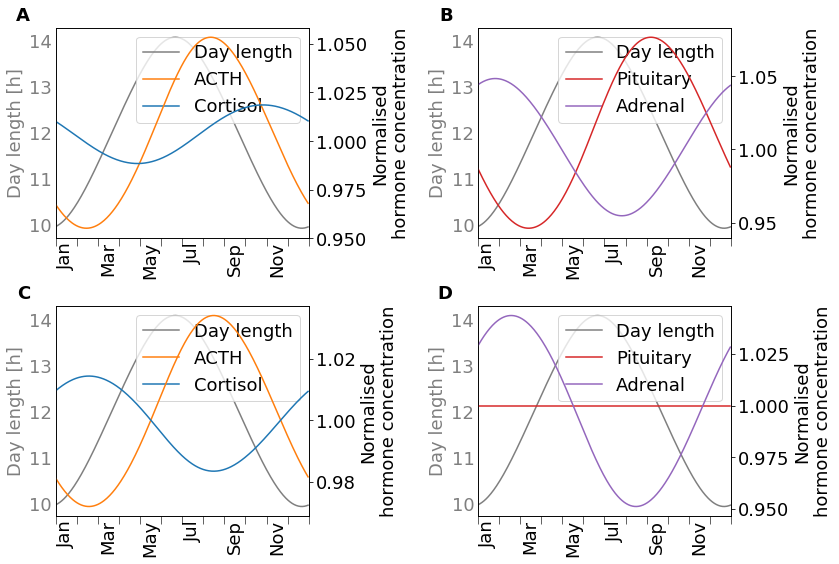

In [29]:
#For the anti-trophic cortisol model

def AdrenalPituitaryCortEqsExact(y,t,timescale='day',phi=31.77,const_pit=False):
    '''
    Simulation of the seasonal input of the HPA axis
    phi- the latitude (default 31.77 the latitude in Jerusalem)
    '''
    [a1_,a2_,a3_,aA_,aP_,b1_,b2_,b3_,bA_,bP_]=get5eqsparams(timescale)
    if const_pit:
        aP_=0
        bP_=0
    #compute input amplitude using sunrise equation
    u_=2-daylen(phi,delta=23.44*np.cos(2*np.pi*((t+10)/365))*np.pi/180)/12
    x2_=stst[1].subs({a1:a1_,a2:a2_,a3:a3_,b1:b1_,b2:b2_,b3:b3_,u:u_,P:y[1],A:y[0]})
    x3_=stst[2].subs({a1:a1_,a2:a2_,a3:a3_,b1:b1_,b2:b2_,b3:b3_,u:u_,P:y[1],A:y[0]})
    [A_,P_] = y
    dy=np.empty(2)
    dy[0]= A_*(bA_*x2_-aA_) #Adrenal cells
    dy[1]= P_*(bP_/x3_-aP_) #Pituitary cells
    return dy


phi=31.77#jerusalem
t=np.linspace(0,3*365-1,3*365)
day_length=daylen(31.77,delta=23.44*np.cos(2*np.pi*((t+10)/365))*np.pi/180)[:365]
sol=odeint(lambda y,t:AdrenalPituitaryCortEqsExact(y,t,timescale='day',phi=31.77),[1,1],t)
adrenal=sol[2*365:3*365,0]
pituitary=sol[2*365:3*365,1]
cortisol=adrenal**(1/3.)*pituitary**(1/3.)
ACTH=adrenal**(-2/3.)*pituitary**(1/3.)



fig,axes=plt.subplots(2,2, figsize=(12,8))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
   
ax1=axes[0][0]
ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
theory_two_scales(ax1,np.arange(365)/365*12,day_length,ACTH,cortisol,'ACTH','Cortisol',def_color[1],def_color[0])  

ax1=axes[0][1]
ax1.text(-0.1, 1.1, 'B', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
theory_two_scales(ax1,np.arange(365)/365*12,day_length,pituitary,adrenal,'Pituitary','Adrenal',def_color[3],def_color[4])  


sol=odeint(lambda y,t:AdrenalPituitaryCortEqsExact(y,t,timescale='day',phi=31.77,const_pit=True),[1,1],t)
adrenal=sol[2*365:3*365,0]
pituitary=sol[2*365:3*365,1]
cortisol=adrenal**(1/3.)*pituitary**(1/3.)
ACTH=adrenal**(-2/3.)*pituitary**(1/3.)

ax1=axes[1][0]
ax1.text(-0.1, 1.1, 'C', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
theory_two_scales(ax1,np.arange(365)/365*12,day_length,ACTH,cortisol,'ACTH','Cortisol',def_color[1],def_color[0])  

ax1=axes[1][1]
ax1.text(-0.1, 1.1, 'D', transform=ax1.transAxes, fontweight='bold', va='top', ha='right')
theory_two_scales(ax1,np.arange(365)/365*12,day_length,pituitary,adrenal,'Pituitary','Adrenal',def_color[3],def_color[4])

plt.tight_layout()

plt.savefig('../figures/antitrophic_cort_seasonality.pdf',bbox_inches='tight',dpi=600)

In [30]:
def plot_dict_with_num_tests(test_dict,files,fig=None,percentile_type='healthy_no_medsraw',\
                infection_type='with_infection',percent_discard='0.05',\
              linestyle='-',color=def_color[0],text_loc=[0.1,0.1],alpha=1,cosinor_fit=False):
    n=len(test_dict)
    if fig==None:
        fig=plt.figure(figsize=(16, 5*n))
    filtered_files=[]
    for i,k in enumerate(test_dict.keys()):
        hormone_file=filter_files(files,hormone=k,percentile_type=percentile_type,\
                                   infection_type=infection_type,percent_discard=percent_discard)[0]
        female_dat=get_seasonal_data(hormone_file,'female')
        ax=fig.add_subplot(n,3,3*i+1)
        plot_dat(female_dat,ax,ylab='Women\n'+test_dict[k],\
                linestyle=linestyle,color=color,text_loc=text_loc,alpha=alpha)
 
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(np.arange(12)+0.5,female_dat['n'])
        ax2.set_ylabel('N')
        ax2.set_xlim([0,12])
        if cosinor_fit:
             plot_cosinor_fit(female_dat,ax)   
        
        ax.text(-0.05, 1.15, chr(ord('A')+i), transform=ax.transAxes, fontweight='bold', va='top', ha='right')


        male_dat=get_seasonal_data(hormone_file,'male')
        ax=fig.add_subplot(n,3,3*i+2)
        plot_dat(male_dat,ax,ylab='Men\n'+test_dict[k],\
                 linestyle=linestyle,color=color,text_loc=text_loc,alpha=alpha)
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(np.arange(12)+0.5,male_dat['n'])
        ax2.set_ylabel('N')
        ax2.set_xlim([0,12])
        if cosinor_fit:
            plot_cosinor_fit(male_dat,ax) 
            
        both_dat=get_seasonal_data(hormone_file,'both')
        ax=fig.add_subplot(n,3,3*i+3)
        plot_dat(both_dat,ax,ylab=test_dict[k],\
                 linestyle=linestyle,color=color,text_loc=text_loc,alpha=alpha)
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.plot(np.arange(12)+0.5,both_dat['n'])
        ax2.set_ylabel('N')
        ax2.set_xlim([0,12])
        if cosinor_fit:
            plot_cosinor_fit(both_dat,ax) 

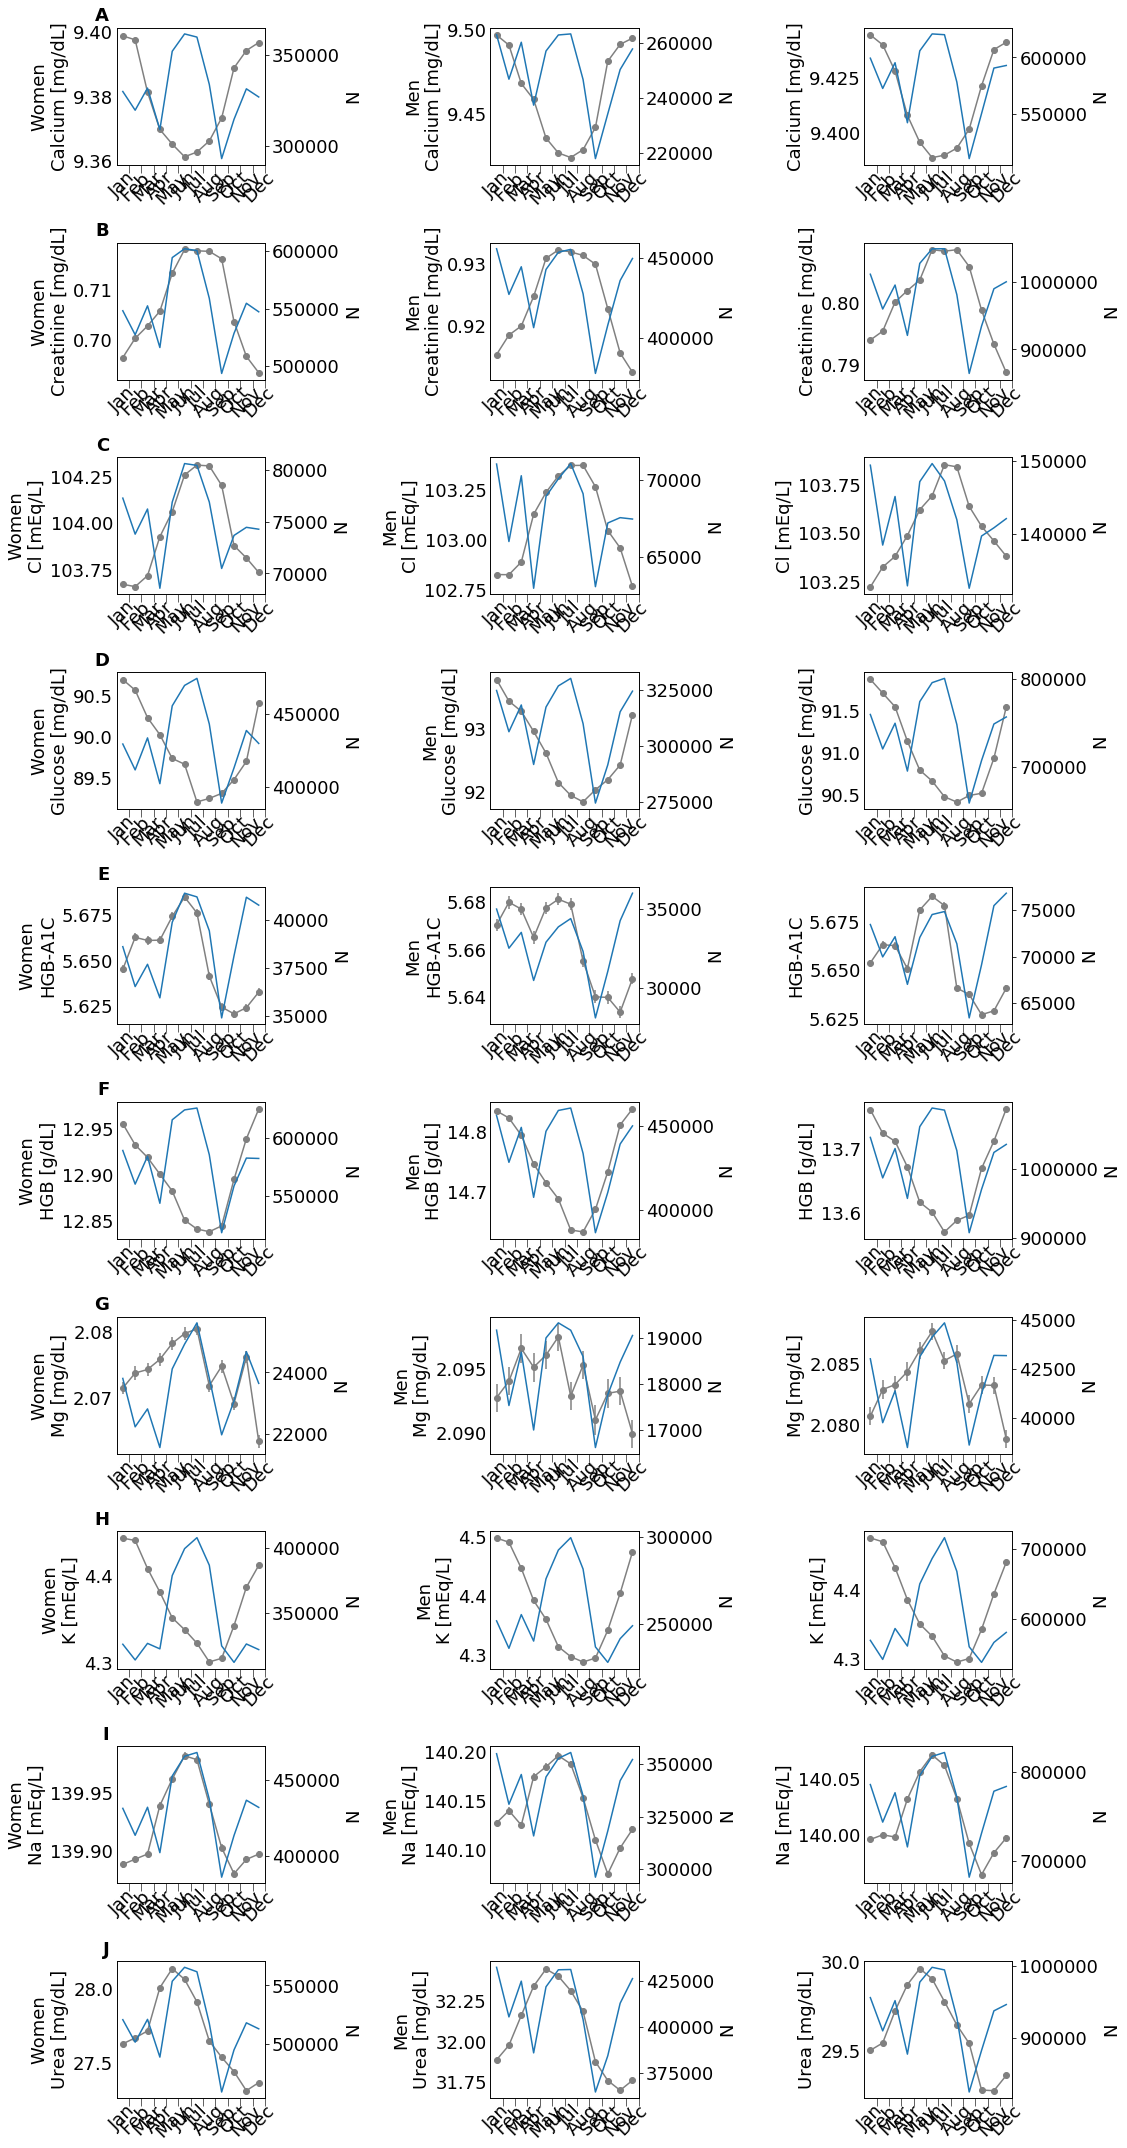

In [31]:
#Just to check variablity in N across seasons

fig=plt.figure(figsize=(16, 3*len(chemistry)))
plot_dict_with_num_tests(chemistry,files,fig=fig,percentile_type='healthy_no_medsraw',\
          percent_discard='0.05',infection_type='with_infection',color='gray',text_loc=None)
plt.tight_layout()

